Evolution of a gas disk.
Following equations 5.3 and 5.9 of "Accretion Power in Astrophysics".

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.special import *
%matplotlib inline

Using matplotlib backend: Qt5Agg


In [12]:
def InitialCondition_Delta(r,r0,Sigma0):
    dr=r[1]-r[0]
    Sigma=np.zeros(r.size)
    delta= np.where(np.fabs(r-r0)<=dr)[0]
    
    Sigma[delta]=Sigma0* (1.0 - np.fabs(r-r0)[delta]/dr) 
    return Sigma

def InitialCondition_PowerLaw(r,r0,Sigma0,exp):
    
    return Sigma0*np.power(r/r0,exp)


In [13]:
def BoundaryCondition_InnerCopy(r,Sigma):
    Sigma[0]=Sigma[1]
    
def BoundaryCondition_OuterCopy(r,Sigma):
    Sigma[nr-1]=Sigma[nr-2]
    

def BoundaryCondition_Inner(r,Sigma,boundary):
    Sigma[0]=boundary
    
def BoundaryCondition_Outer(r,Sigma,boundary):
    Sigma[-1]=boundary    

In [14]:
def CFL_Condition_Vel(dr,u):
    v_max=np.amax(u)
    if v_max>0:
        Courant_Vel= np.divide(0.1*dr,v_max)
        return np.amin(Courant_Vel)
    else:
        return np.infty

In [15]:
def Compute_Velocity(r,Sigma,visc):
    nr=r.size
    dr=r[1]-r[0]
    Sigr= np.multiply(Sigma,np.sqrt(r))
    
    r_05=0.5*(r[0:nr-1]+r[1:nr])
    Sigr_05= 0.5*(Sigr[0:nr-1]+Sigr[1:nr])
    d_Sigr_05= (Sigr[1:nr]-Sigr[0:nr-1])/dr

    u_05 = -3.0*visc*np.divide(d_Sigr_05,Sigr_05)
    u_inter=interp1d(r_05,u_05,kind="linear",fill_value="extrapolate")
    
    return u_inter(r)
    
    

In [16]:
def DonnorCell_Advection(r,q,u):
    nr=r.size
    dr=r[1]-r[0]
    
    u_05= 0.5*(u[0:nr-1]+u[1:nr]) #Velocity at the Interfaces
    flux_05= np.zeros(nr-1)  #Flux at the interfaces
    
    positive=np.where(u_05>0)[0]  #Interfaces where the flux comes from the left
    negative=np.where(u_05<0)[0]  #Interfaces where the flux comes from the right
        
    flux_05[positive]= np.multiply(q[positive], u_05[positive])
    flux_05[negative]= np.multiply(q[negative+1], u_05[negative])
    
    q_flux=np.zeros(nr)
    q_flux[1:nr-1]= (flux_05[0:nr-2]-flux_05[1:nr-1])/dr  #Notice that the cell 0 and nr-1 are ignored
    
    return q_flux

In [17]:
Mstar=1.0           #Solar Mass
r0=1.0              #AU
visc=0.001          #Weird Units
m_disk=0.01*Mstar   #Disk mass

t_orbit=2.0*np.pi
t_visc=r0*r0/(12.0*visc)

nr=500
r_min=0.01
r_max=2.0

dr=(r_max-r_min)/nr
r=np.linspace(r_min+0.5*dr,r_max-0.5*dr,num=nr,endpoint=True)

t_start=0.0*t_visc
t_end=0.512*t_visc
dt=0.001*t_visc



#t_output=np.power(2.0, np.array([1.0,3.0,5.0,7.0,9.0]))/1000.0
#t_output=(t_end-t_start)/5.0
t_output=0.002*t_visc



Sigma0=m_disk/(2.0*np.pi*r0*dr)
Sigma=InitialCondition_Delta(r,r0,Sigma0)+0.0001*Sigma0
#Sigma=InitialCondition_PowerLaw(r,r0,Sigma0,-1.5)
u=Compute_Velocity(r,Sigma,visc)

floor_Sigma=np.amin(Sigma)



In [18]:
t=t_start
t_save=t_output

Output_Dens=[]
Output_Dens.append(np.copy(Sigma))

while t<t_end:
    
    #Find the timestep using Courant Condition
    dt_0=np.amin([dt,t_output-t,CFL_Condition_Vel(dr,u)])
    
    #Evolve the Density*Radius through advection
    Argument=np.multiply(r,Sigma)
    dArg_dt=np.zeros(nr)    
    dArg_dt+=DonnorCell_Advection(r,Argument,u)
    Argument+=dArg_dt*dt_0
    Sigma=np.divide(Argument,r)
    
    #Apply Boundary Conditions
    #Notice that the cells 0 and nr-1 are treated as ghost cells and never touched except by the boundary conditions
    #BoundaryCondition_BothSides(r,Sigma,0.0)
    BoundaryCondition_InnerCopy(r,Sigma)
    BoundaryCondition_Outer(r,Sigma,floor_Sigma)

    u=Compute_Velocity(r,Sigma,visc)
    
    
    
    #Check if it is time to save
    t+=dt_0
    if t_output-t<=0.0:
        t_output=t_output*4.0
        Output_Dens.append(np.copy(Sigma))
    #Update the Time


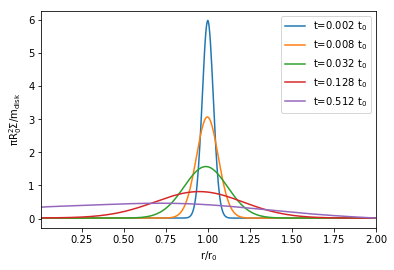

In [22]:
plt.xlabel("$\mathdefault{r/r_0}$")
plt.ylabel("$\mathdefault{\pi R_0^2\Sigma/m_{disk}}$")
plt.xlim([r_min,r_max])
#plt.ylim([0.0,0.01])

#plt.plot(r/r0, Analytic_Density(r,0.00000001*t_output,r0,Sigma0,visc)/Sigma0,"r--",label="t="+str(np.around(t_output*s/t_orbit,decimals=1))+" $\mathdefault{t_0}$" )
    
for s in range(1,len(Output_Dens)):
    plt.plot(r/r0, np.pi*r0*r0*Output_Dens[s]/m_disk,label="t="+str(2.0**(2.0*s-1.0)/1000.0)+" $\mathdefault{t_0}$" )
    plt.legend()